# Bidirectional trajectories of stroke and psychosis: A 16-year longitudinal population study of older adults

## Psychosis After Stroke analysis

In [24]:
library(dplyr)
library(survival)
library(survminer)
library(forestmodel)

Load pre-processed dataframe created by Stroke_Psychosis_ELSA_Pre-processing.R

In [2]:
transformed_data_dir = "/home/main/data/StrokePsychosisELSATransformedData/"
transformed_data_filename = paste(transformed_data_dir, "waves12345.rda", sep="")

load(file = transformed_data_filename)

#### Recode and arrange data

In [3]:
psychosisinstroke_surv <- waves12345 %>%
  select(idauniq, wavefirstparticipate, wavelastparticipate, wavefirstreport_stroke, wavefirstreport_psychosis, strokeever, psychosisever, 
         w1age, sex, ethnicgroup, alcoholbaseline, smokingbaseline, vigorousactbaseline, netwealth_q5, region, age_cat)

# Get data into right format
psychosisinstroke_surv$wavefirstparticipate <- as.numeric(psychosisinstroke_surv$wavefirstparticipate)
psychosisinstroke_surv$wavelastparticipate <- as.numeric(psychosisinstroke_surv$wavelastparticipate)
psychosisinstroke_surv$wavefirstreport_stroke <- as.numeric(psychosisinstroke_surv$wavefirstreport_stroke)
psychosisinstroke_surv$wavefirstreport_psychosis <- as.numeric(psychosisinstroke_surv$wavefirstreport_psychosis)
psychosisinstroke_surv$strokeever <- as.numeric(psychosisinstroke_surv$strokeever)
psychosisinstroke_surv$psychosisever <- as.numeric(psychosisinstroke_surv$psychosisever)
psychosisinstroke_surv$netwealth_q5 <- factor(psychosisinstroke_surv$netwealth_q5, levels = c(5, 4, 3, 2, 1))

# Assign numeric labels to cateogrical variables (reference group == 1 i.e. the most healthy level of the variable). 
# If the categories are used then results are not shown in an order than makes sense.

# Vigorous physical activity
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "hardly ever, or never"] <- 4
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "one to three times a month"] <- 3
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "once a week"] <- 2
psychosisinstroke_surv$vigorousactbaseline[psychosisinstroke_surv$vigorousactbaseline == "more than once a week"] <- 1

# Alcohol use
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "1-4 times/week"] <- 5
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Daily/almost daily"] <- 4
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Monthly"] <- 3
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Rarely/special occasions only"] <- 2
psychosisinstroke_surv$alcoholbaseline[psychosisinstroke_surv$alcoholbaseline == "Not at all"] <- 1

# Rename variables with more print appropriate names (these appear directly on the forest plot/outputs)
psychosisinstroke_surv <- psychosisinstroke_surv %>% 
  mutate(`Age at Wave 1` = w1age,
         `Wealth quintile` = netwealth_q5,
         `Stroke status` = strokeever,
         Sex = sex,
         `Ethnic group` = ethnicgroup,
         `Alcohol consumption` = alcoholbaseline,
         `Smoking status` = smokingbaseline,
         `Vigorous activity` = vigorousactbaseline)

# Create follow-up time variables
psychosisinstroke_surv <- psychosisinstroke_surv %>%
  mutate(fuptime = case_when(psychosisever == 1 & strokeever == 0 ~ wavefirstreport_psychosis - wavefirstparticipate, #psychosis but no stroke, f-up starts from wave first participated until first report of psychosis
                              psychosisever == 0 & strokeever == 1 ~ wavelastparticipate - wavefirstreport_stroke, #stroke but no psychosis, f-up starts from wave stroke first reported until wave last participated
                              psychosisever == 0 & strokeever == 0 ~ wavelastparticipate - wavefirstparticipate, #no stroke and no psychosis, use full available follow-up (from first wave to last wave participated)
                              wavefirstreport_psychosis > 0 & wavefirstreport_psychosis < wavefirstreport_stroke ~ 0, #if first psychosis report happened prior to report of stroke, then f-up time = 0
                              wavefirstreport_stroke == wavefirstreport_psychosis ~ 0, #if stroke and psychosis reported at the same time, then f-up time = 0
                              psychosisever == 1 & strokeever == 1 ~ wavefirstreport_psychosis - wavefirstreport_stroke, #psychosis and stroke, f-up starts from first report of stroke until psychosis is reported
                              TRUE ~ 999))      

# Convert follow-up time from waves to years (follow-up occurred every two years i.e. *2)
psychosisinstroke_surv <- psychosisinstroke_surv %>%
  mutate(fuptime = fuptime * 2)

Summarise follow-up time (in years)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   2.000   6.000   7.169  12.000  17.000 

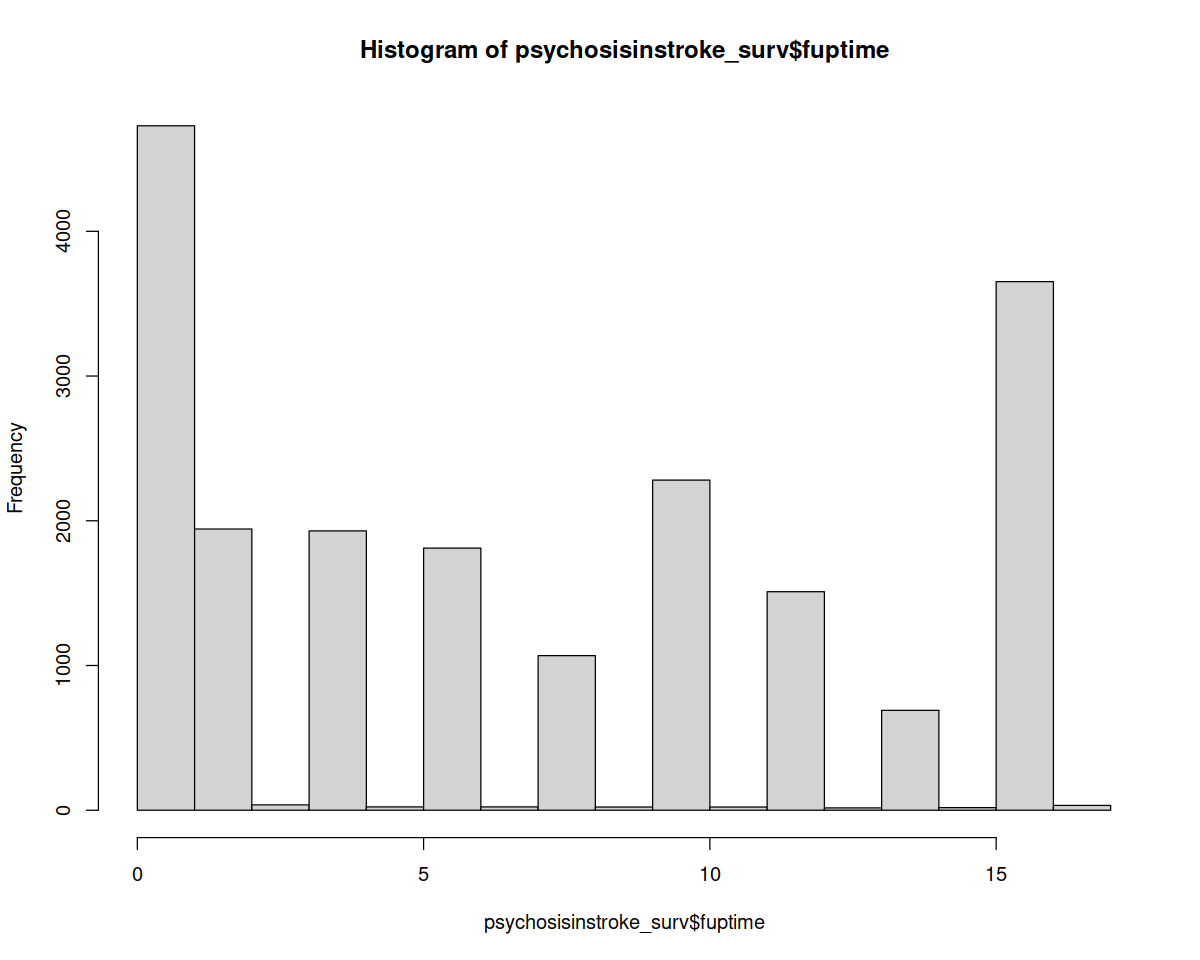

In [4]:
summary(psychosisinstroke_surv$fuptime)

options(repr.plot.width=10, repr.plot.height=8)
hist(psychosisinstroke_surv$fuptime)

Summarise by stroke status

In [5]:
psychosisinstroke_surv %>%
  group_by(strokeever) %>%
  summarise(mean = mean(fuptime), 
            median = median(fuptime), 
            iqr_low = quantile(fuptime, probs =c(.25)), 
            iqr_upper = quantile(fuptime, probs =c(.75))
  )

strokeever,mean,median,iqr_low,iqr_upper
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,7.349613,6,2,12
1,4.900821,4,1,8


#### Build survival model

In [6]:
survobj <- Surv(time = psychosisinstroke_surv$fuptime,
                event = psychosisinstroke_surv$psychosisever)

#### Produce Kaplan-Meier estimates and curves

This creates and summarises an overall survival curve on the entire sample

In [7]:
surv_fit <- survfit(survobj ~ 1)
summary(surv_fit)
print(surv_fit, print.rmean = TRUE) # print.rmean shows the mean survival time

Call: survfit(formula = survobj ~ 1)

 time n.risk n.event survival  std.err lower 95% CI upper 95% CI
    0  19808      82    0.996 0.000456        0.995        0.997
    1  15176       3    0.996 0.000470        0.995        0.997
    2  15079      15    0.995 0.000535        0.994        0.996
    4  13099      18    0.993 0.000623        0.992        0.995
    6  11146      11    0.992 0.000689        0.991        0.994
    8   9312      11    0.991 0.000774        0.990        0.993
   10   8222      10    0.990 0.000862        0.988        0.992
   12   5919       5    0.989 0.000939        0.987        0.991
   14   4393       4    0.988 0.001040        0.986        0.990
   16   3685       3    0.987 0.001138        0.985        0.990

Call: survfit(formula = survobj ~ 1)

         n events rmean* se(rmean) median 0.95LCL 0.95UCL
[1,] 19808    162   16.9    0.0113     NA      NA      NA
    * restricted mean with upper limit =  17 


#### Stratified survival

In [8]:
psychosisinstroke_fit <- survfit(Surv(fuptime, psychosisever) ~ strokeever, data = psychosisinstroke_surv)
psychosisinstroke_fit # not possible to calculate median survival here as not enough events accrued during follow-up to reach median
summary(psychosisinstroke_fit)
print(psychosisinstroke_fit, print.rmean = TRUE) # print.rmean shows the mean survival time

Call: survfit(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

                 n events median 0.95LCL 0.95UCL
strokeever=0 18346    138     NA      NA      NA
strokeever=1  1462     24     NA      NA      NA

Call: survfit(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

                strokeever=0 
 time n.risk n.event survival  std.err lower 95% CI upper 95% CI
    0  18346      68    0.996 0.000449        0.995        0.997
    2  14074      13    0.995 0.000516        0.994        0.996
    4  12354      13    0.994 0.000591        0.993        0.995
    6  10593      11    0.993 0.000668        0.992        0.995
    8   8903      11    0.992 0.000763        0.991        0.994
   10   7910      10    0.991 0.000859        0.989        0.992
   12   5723       5    0.990 0.000941        0.988        0.992
   14   4256       4    0.989 0.001049        0.987        0.991
   16   3605       3    0.988 0.001151        0.986        0.990

                strokeever=1 
 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    0   1462      14    0.990 0.00255        0.985        0.995
    1   1102       3    0.988 0.00298        0.982       

Call: survfit(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

                 n events rmean* se(rmean) median 0.95LCL 0.95UCL
strokeever=0 18346    138   16.9    0.0111     NA      NA      NA
strokeever=1  1462     24   16.7    0.0659     NA      NA      NA
    * restricted mean with upper limit =  17 


#### Compute log rank test statistic (test of whether the curves are overlapping or not)

In [9]:
survdiff(
  Surv(fuptime, psychosisever) ~ strokeever,
  data = psychosisinstroke_surv
)

Call:
survdiff(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

                 N Observed Expected (O-E)^2/E (O-E)^2/V
strokeever=0 18346      138    151.9      1.28      20.7
strokeever=1  1462       24     10.1     19.33      20.7

 Chisq= 20.7  on 1 degrees of freedom, p= 5e-06 

#### Generate survival curves plot

Warning message in .add_surv_median(p, fit, type = surv.median.line, fun = fun, :
“Median survival not reached.”
Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


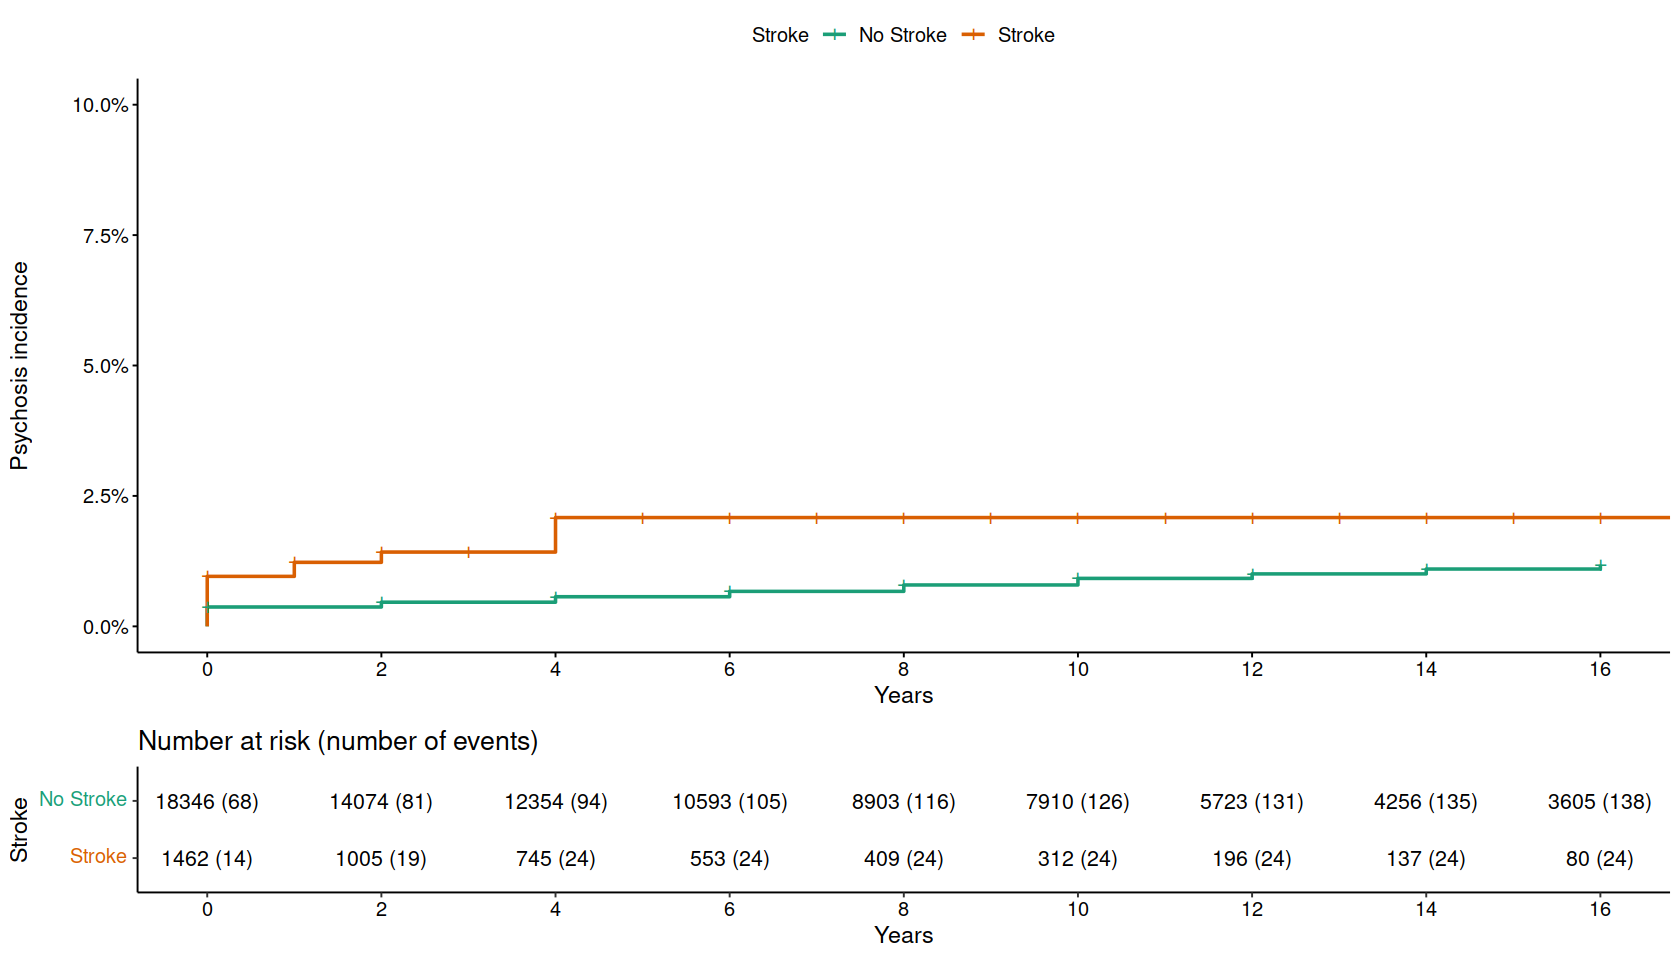

In [10]:
# Set plot size
options(repr.plot.width=14, repr.plot.height=8)

# Plot
ggsurvplot(
  psychosisinstroke_fit,         # survival object already created above
  data = psychosisinstroke_surv,
  conf.int = FALSE,              # whether to display CIs on plot
  fun = "event",
  surv.scale = "percent",        # present probabilities in the y axis in %
  break.time.by = 2,            # present the time axis with an increment of 1 days
  xlab = "Years",
  ylab = "Psychosis incidence",
  ylim = c(0, .10),
  pval = T,                      # print p-value of Log-rank test (this does not seem to appear?)
  pval.coord = c(40,.91),        # print p-value at these plot coordinates
  risk.table = "nrisk_cumevents",                # print the risk table at bottom. abs_pct = absolute numbers and percentages. Can also use "absolute" or "percentage" alone.
  legend.title = "Stroke",       # legend characteristics
  legend.labs = c("No Stroke","Stroke"),
  font.legend = 12, 
  palette = "Dark2",             # specify color palette 
  surv.median.line = "hv",       # draw horizontal and vertical lines to the median survivals (?but median  survival not met in this data)
)

#### Calculate mean time to stroke after psychosis and time to all presence of known stroke cases

In [11]:
psychosisinstroke_surv %>%
  filter(psychosisever == 1) %>%
  group_by(strokeever) %>%
  summarise(mean=mean(fuptime), sd = sd(fuptime))

strokeever,mean,sd
<dbl>,<dbl>,<dbl>
0,3.594203,4.560442
1,1.125000,1.623536


### Cox proportional hazards regression models

#### Unadjusted model

In [12]:
psychosisinstroke_cox <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ strokeever, 
  data = psychosisinstroke_surv
)

summary(psychosisinstroke_cox)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ strokeever, 
    data = psychosisinstroke_surv)

  n= 19808, number of events= 162 

             coef exp(coef) se(coef)     z Pr(>|z|)    
strokeever 0.9738    2.6481   0.2221 4.384 1.17e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

           exp(coef) exp(-coef) lower .95 upper .95
strokeever     2.648     0.3776     1.713     4.093

Concordance= 0.55  (se = 0.016 )
Likelihood ratio test= 15.32  on 1 df,   p=9e-05
Wald test            = 19.22  on 1 df,   p=1e-05
Score (logrank) test = 20.78  on 1 df,   p=5e-06


Test proportional hazards

In [13]:
cox.zph(psychosisinstroke_cox) # p values are not significant, suggesting the assumptions are not violated

           chisq df    p
strokeever 0.821  1 0.36
GLOBAL     0.821  1 0.36

Resized limits to included dashed line in forest panel



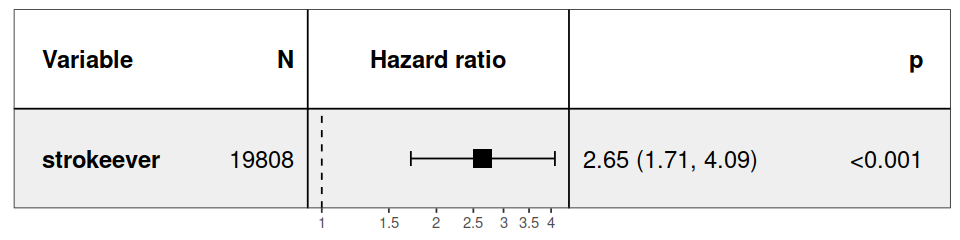

In [14]:
# Set plot size
options(repr.plot.width=8, repr.plot.height=2)

# Plot
forest_model(psychosisinstroke_cox)

#### Adjusted model 1 (with demographic covariates)

In [15]:
psychosisinstroke_coxadj <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + frailty(idauniq), 
  data = psychosisinstroke_surv
)

summary(psychosisinstroke_coxadj)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    frailty(idauniq), data = psychosisinstroke_surv)

  n= 16434, number of events= 145 
   (3374 observations deleted due to missingness)

                        coef     se(coef) se2      Chisq   DF   p      
`Stroke status`          1.42004 0.353588 0.271393   16.13    1 5.9e-05
`Age at Wave 1`         -0.03043 0.009885 0.008278    9.48    1 2.1e-03
SexFemale                0.22780 0.219987 0.177975    1.07    1 3.0e-01
`Ethnic group`Non-White -0.22410 0.595140 0.482815    0.14    1 7.1e-01
`Ethnic group`Unknown    0.55347 0.550856 0.462620    1.01    1 3.2e-01
`Wealth quintile`4       0.32689 0.389702 0.334038    0.70    1 4.0e-01
`Wealth quintile`3       0.45577 0.388423 0.331163    1.38    1 2.4e-01
`Wealth quintile`2       0.65679 0.381262 0.323214    2.97    1 8.5e-02
`Wealth quintile`1       1.68055 0.342087 0.287864   24.13    1 

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


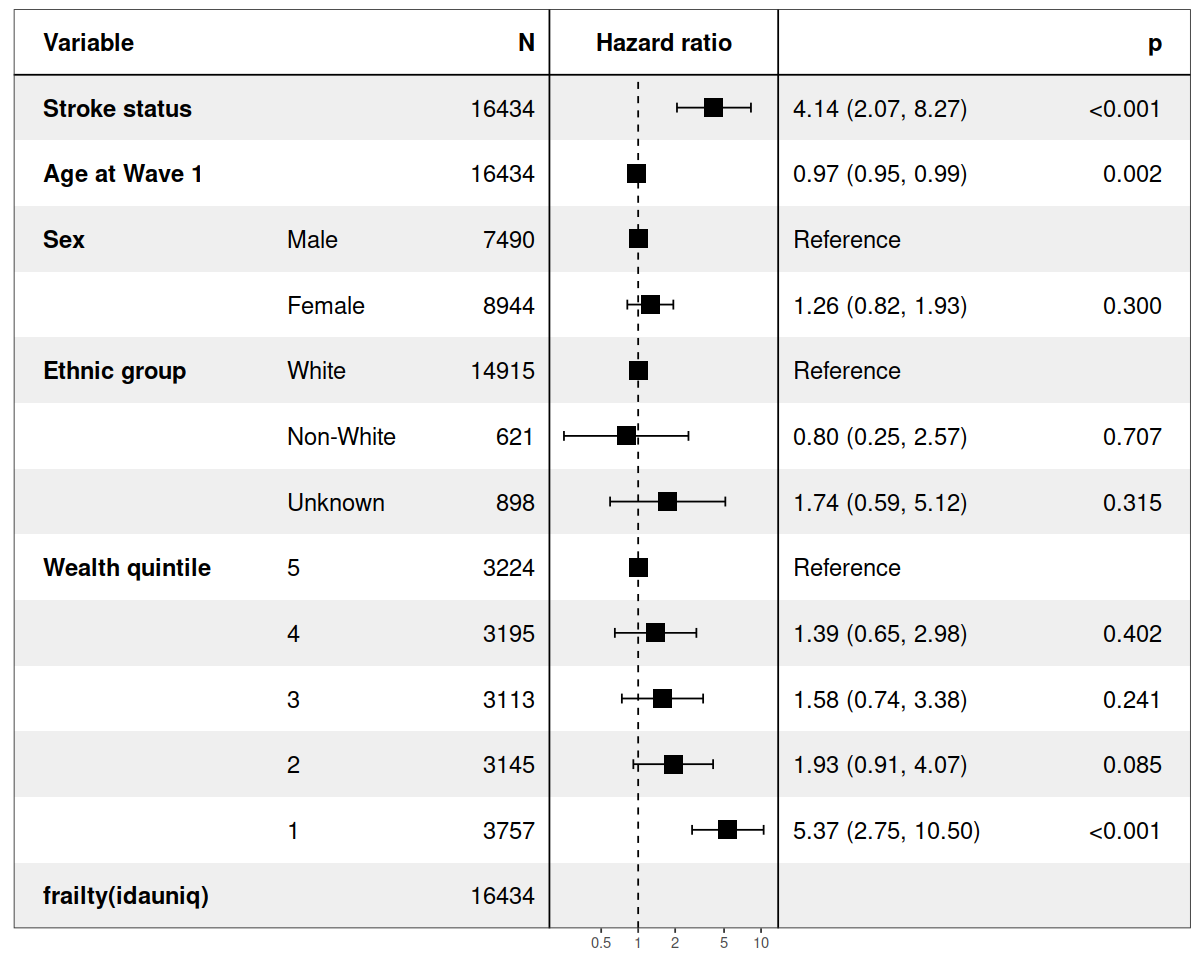

In [16]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadj)

#### Adjusted model 2 (with demographic and health behaviour covariates)

In [17]:
psychosisinstroke_coxadj2 <-  survival::coxph(
  Surv(fuptime, psychosisever) ~ `Stroke status` + `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + `Smoking status` + `Alcohol consumption` + `Vigorous activity` + frailty(idauniq), 
  data = psychosisinstroke_surv
)

summary(psychosisinstroke_coxadj2)

Call:
survival::coxph(formula = Surv(fuptime, psychosisever) ~ `Stroke status` + 
    `Age at Wave 1` + Sex + `Ethnic group` + `Wealth quintile` + 
    `Smoking status` + `Alcohol consumption` + `Vigorous activity` + 
    frailty(idauniq), data = psychosisinstroke_surv)

  n= 14895, number of events= 126 
   (4913 observations deleted due to missingness)

                        coef     se(coef) se2      Chisq   DF   p      
`Stroke status`          1.42621 0.42814  0.319731   11.10    1 8.6e-04
`Age at Wave 1`         -0.04610 0.01228  0.009832   14.10    1 1.7e-04
SexFemale                0.12825 0.26577  0.206555    0.23    1 6.3e-01
`Ethnic group`Non-White -0.04693 0.69825  0.516487    0.00    1 9.5e-01
`Ethnic group`Unknown    0.34700 0.67367  0.555209    0.27    1 6.1e-01
`Wealth quintile`4       0.27603 0.43936  0.355145    0.39    1 5.3e-01
`Wealth quintile`3       0.43984 0.43882  0.353087    1.00    1 3.2e-01
`Wealth quintile`2       0.23904 0.44597  0.357322    0.29    1 5.

Warning message in recalculate_width_panels(panel_positions, mapped_text = mapped_text, :
“Unable to resize forest panel to be smaller than its heading; consider a smaller text size”


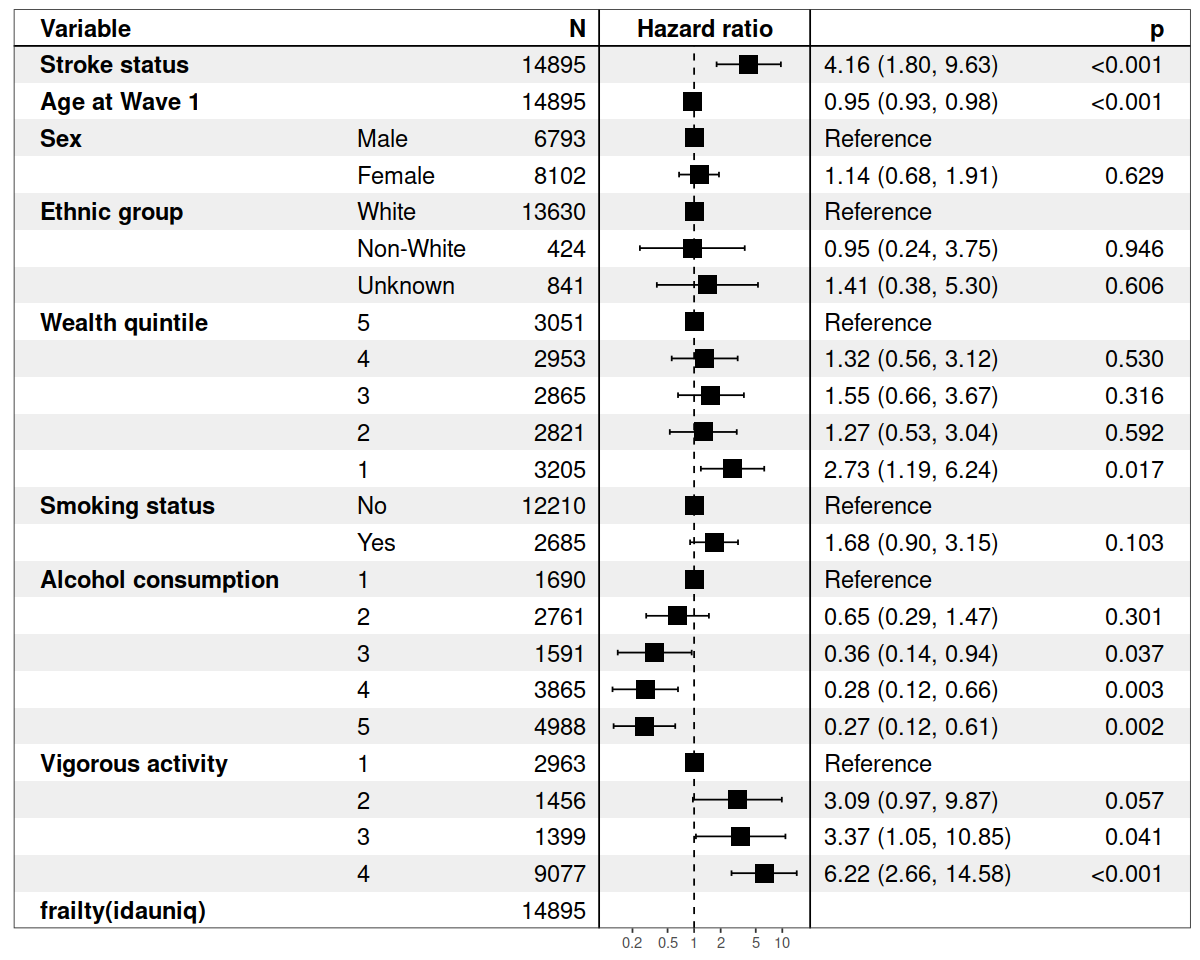

In [18]:
# Set plot size
options(repr.plot.width=10, repr.plot.height=8)

# Plot
forest_model(psychosisinstroke_coxadj2)

## Analysis platform details and software versions

In [19]:
version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          2.0                         
year           2022                        
month          04                          
day            22                          
svn rev        82229                       
language       R                           
version.string R version 4.2.0 (2022-04-22)
nickname       Vigorous Calisthenics       

In [20]:
packageVersion("dplyr")

[1] ‘1.0.9’

In [21]:
packageVersion("survival")

[1] ‘3.2.13’

In [22]:
packageVersion("survminer")

[1] ‘0.4.9’

In [23]:
packageVersion("forestmodel")

[1] ‘0.6.2’